# chemical maps

This notebooks has simple workflows with chemical X-ray data obtained with an electron probe microanalyzer (EMPA), with both EDS (energy-dispersive) and WDS (wavelength-dispersive) spectometers. 
The data is from a high-grade crd-grt granulite with spl-sill from the Araçuaí Orogen, SE Brazil.

Worklows are:
* load and display individual X-ray maps
* train a machine-learning model to classify minerals after getting specific area/points from the map and classify all other data points
* load mineral chemistry standards and use a cluster algorithm to classify all pixels


In [2]:
# importing libs
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.utils import get_dirs

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest

In [3]:
get_dirs()

{'SOURCE_DIR': '/home/orogen/code/xmapy',
 'DATA_DIR': '/home/orogen/code/xmapy/data',
 'FIGS_DIR': '/home/orogen/code/xmapy/figs',
 'QUERY_DIR': '/home/orogen/code/xmapy/queries',
 'PLOT_DIR': '/home/orogen/code/xmapy/plots'}

In [ ]:
# setting up plots
plt.rcParams["figure.figsize"] = (16,8)

# setting up directories
SOURCE_DIR = os.path.abspath('.')
DATA_DIR = os.path.join(SOURCE_DIR, 'data')
FIGS_DIR = os.path.join(SOURCE_DIR, 'figs')
QUERY_DIR = os.path.join(SOURCE_DIR, 'queries')
PLOT_DIR = os.path.join(SOURCE_DIR, 'plots')

ELEMENTS = ["Al","Ba","Ca","Cl","Cr","Fe","K","Mg","Mn","Mn","Na","P","S","Si","Ti","Zn","Zr"]

In [ ]:
# load files


def load_maps():
  """
  Function that read all x-ray maps from a specific dir. It returns a list for numpy arrays, scaled to 255
  and ready from diplay with plt.imgshow()

  In this example, x-ray maps are csv files without headers, have intensities as integers and are located
  on DATA_DIR
  """
  maps = []
  for el in ELEMENTS:
    try:
      # print('{a}.csv'.format(a=el))
      df_el = pd.read_csv(os.path.join(DATA_DIR, '{element}.csv'.format(element=el)), dtype="Int64", header=None)
      maps.append(df_el)
      print('{a}.csv found!'.format(a=el))
    except:
      print("error loading map")

  maps_np = [x.to_numpy().astype(np.float32) / 255.0 for x in maps]


  return maps_np
  # print(maps)

Al.csv found!
Ba.csv found!
Ca.csv found!
Cl.csv found!
Cr.csv found!
Fe.csv found!
K.csv found!
Mg.csv found!
Mn.csv found!
Mn.csv found!
Na.csv found!
P.csv found!
S.csv found!
Si.csv found!
Ti.csv found!
Zn.csv found!
Zr.csv found!


In [17]:
maps_np[0]

array([[24.541176 , 23.945099 , 23.52549  , ..., 14.57647  , 15.172549 ,
        14.592156 ],
       [24.09804  , 24.137255 , 24.305882 , ..., 14.756863 , 14.784314 ,
        14.639215 ],
       [22.843138 , 23.701962 , 24.658823 , ..., 14.541177 , 15.505882 ,
        14.415687 ],
       ...,
       [14.780392 , 14.439216 , 15.       , ...,  9.909804 , 10.270588 ,
        10.521568 ],
       [14.709804 , 14.572549 , 14.494118 , ..., 13.09804  , 10.501961 ,
        11.384314 ],
       [14.3294115, 14.6784315, 14.592156 , ..., 14.870588 , 14.811765 ,
        14.192157 ]], dtype=float32)

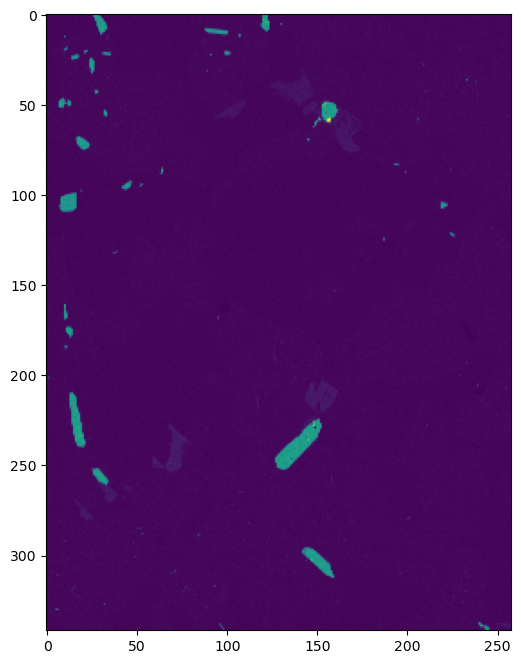

In [15]:
plt.imshow(maps_np[1])
plt.show()

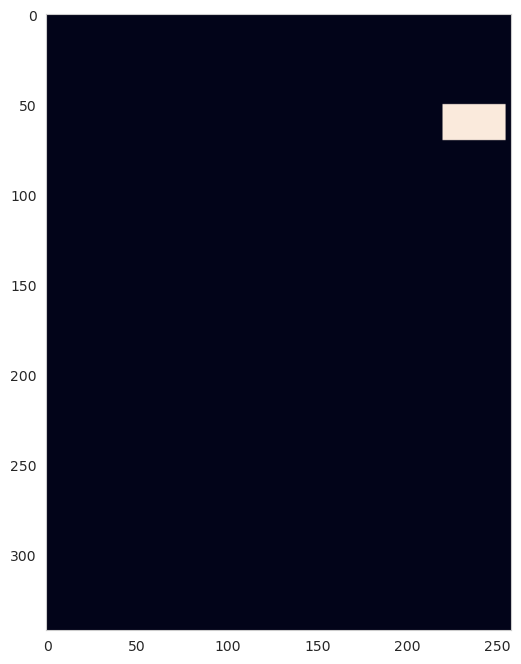

In [186]:
df_Al

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,256,257
0,6258,6106,5999,6237,6148,6150,6036,6192,6068,6160,...,3788,3653,3839,3748,3623,3727,3866,3717,3869,3721
1,6145,6155,6198,6210,6027,5869,6031,5801,6142,6138,...,3831,3766,3733,3789,3698,3860,3797,3763,3770,3733
2,5825,6044,6288,6076,6063,6106,5686,6120,6196,6114,...,3778,3824,3780,3751,3773,3660,3779,3708,3954,3676
3,6112,6137,6250,6123,6200,6055,5974,6198,6141,6151,...,3690,3778,3720,3724,3809,3755,3787,3746,3659,3766
4,6076,6205,6096,6185,6277,6075,6307,6163,6143,6013,...,3760,3666,3751,3745,3722,3645,3769,3790,3846,3724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,3789,3785,3925,3865,3759,3715,3750,3780,3635,3894,...,4147,3223,316,212,1409,2795,834,101,64,2371
338,3871,3692,3826,3790,3697,3728,3806,3891,3870,3849,...,3701,3577,2533,2214,1880,1417,2391,1631,999,453
339,3769,3682,3825,3862,3642,3797,3748,3729,3817,3861,...,3720,3716,3744,3572,3097,2916,2553,2527,2619,2683
340,3751,3716,3696,3797,3784,3917,3736,3722,3661,3756,...,3654,3718,3728,3729,3845,3609,3497,3340,2678,2903


In [187]:
df_Fe

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,256,257
0,622,567,584,587,537,589,550,543,583,553,...,33,25,29,22,24,32,30,22,23,28
1,527,565,559,649,614,555,554,568,566,580,...,23,26,26,26,23,23,25,32,34,30
2,576,537,577,554,585,598,590,558,587,603,...,19,18,27,20,21,25,22,20,29,31
3,571,592,580,570,594,575,577,614,602,590,...,29,19,23,27,19,22,27,28,24,28
4,592,622,564,583,576,554,626,608,608,590,...,27,29,23,25,17,17,30,28,24,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,26,32,23,107,31,23,29,36,24,32,...,1335,300,162,73,293,534,147,65,56,272
338,18,28,24,28,32,26,30,56,28,25,...,3120,1930,1566,982,775,710,1114,786,447,138
339,23,28,38,19,83,20,28,22,20,24,...,3411,3434,3362,3188,2435,2054,1416,1242,1196,1163
340,28,29,31,21,59,29,30,30,29,32,...,3267,3199,3371,3347,3389,3370,3299,2937,2091,2026


In [118]:
np.stack([df_Al, df_Fe], axis=-1).shape

(342, 258, 2)

In [188]:
df_al_fe = np.stack([df_Al, df_Fe, df_Mg, df_Si, true_grt], axis=-1)
print(df_al_fe.shape)

(342, 258, 5)


In [193]:
df_good = pd.DataFrame(df_al_fe.reshape(-1, df_al_fe.shape[-1]), columns=["Al","Fe","Mg","Si", "flGrt"])
df_good_labeled = df_good[df_good.flGrt == 1]


* ML

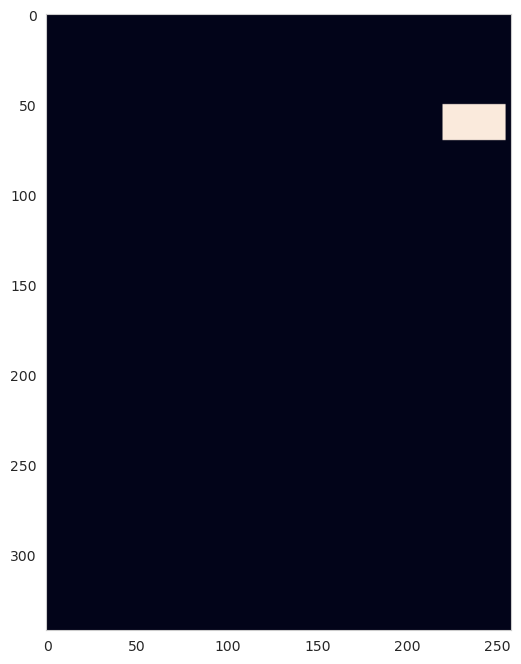

In [ ]:
# creating a fake mask to 

true_grt = np.zeros(maps_np[0].shape)
true_grt[50:70,220:255] = 1
plt.imshow(true_grt)
plt.show()

In [197]:
X = df_good_labeled[["Al", "Fe", "Mg", "Si"]]
y = df_good_labeled["flGrt"].astype(int)

model = LogisticRegression()
model_forest = IsolationForest()
model_forest.fit(X)

IsolationForest()

In [212]:
df_to_predict = df_good.drop(columns=["flGrt"], inplace=False)

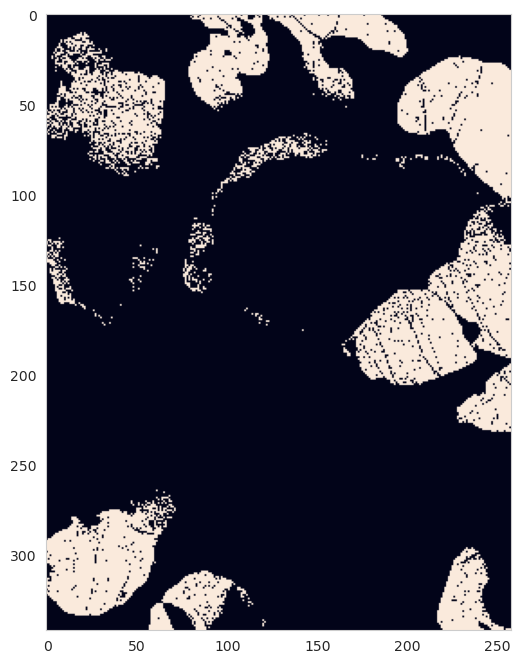

In [213]:
plt.imshow(model_forest.predict(df_to_predict).reshape(342, 258))